In [1]:
# Imports
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import *
from keras import backend
%load_ext autoreload
%autoreload 2


/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

In [3]:
# Load data
DATA_PATH = "../../data/simulated/"
OUTPUT_PATH = "../../data/output/"
MODEL_PATH = OUTPUT_PATH + "models/"


# Images are NOT normalized, positions are normalized (div by 16) to [0,1] interal
images = np.load(DATA_PATH + "test_images_double_1M.npy")
energies = np.load(DATA_PATH + "test_energies_double_1M.npy")
positions = np.load(DATA_PATH + "test_positions_double_1M.npy")

# shape is (x1, y1, x2, y2, E1, E2)
y_pred = np.load(DATA_PATH + "test_y_pred_double_1M.npy")
targets = np.concatenate((positions, energies), axis=1)


print("Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Targets shape: {}".format(targets.shape))
print("Predictions shape: {}".format(y_pred.shape))

Images shape: (100000, 16, 16, 1)
Energies shape: (100000, 2)
Positions shape: (100000, 4)
Targets shape: (100000, 6)
Predictions shape: (100000, 6)


In [4]:
# Custom functions
# Define R2 score in numpy
eps = 1e-13
def r2_score(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + eps) )


In [5]:
# Statistics about the data
single, double, close = event_indices(positions*16*3) #scale to mm

print("Number of single events:", len(single))
print("Number of double events:", len(double))
print("Number of close events:", len(close))

Number of single events: 0
Number of double events: 100000
Number of close events: 514


In [6]:
# Get some numbers about the residuals for double events

y_resid = targets - y_pred

print("X1 residuals mean: {:g}".format(np.mean(y_resid[double,0])))
print("Y1 residuals mean: {:g}".format(np.mean(y_resid[double,1])))
print("X2 residuals mean: {:g}".format(np.mean(y_resid[double,2])))
print("Y2 residuals mean: {:g}".format(np.mean(y_resid[double,3])))
print("E1 residuals mean: {:g}".format(np.mean(y_resid[double,4])))
print("E2 residuals mean: {:g}".format(np.mean(y_resid[double,5])))

rel_dist = relative_distance(positions)
rel_E = relative_energy(energies)

X1 residuals mean: 0.0174777
Y1 residuals mean: 0.00377096
X2 residuals mean: -0.00035477
Y2 residuals mean: -0.00593064
E1 residuals mean: -0.0241244
E2 residuals mean: -0.0264198


In [8]:
# Individual R2-scores for each target for double events
print("X1 r2 = {:g}".format(r2_score(targets[double, 0], y_pred[double, 0])))
print("Y1 r2 = {:g}".format(r2_score(targets[double, 1], y_pred[double, 1])))
print("X2 r2 = {:g}".format(r2_score(targets[double, 2], y_pred[double, 2])))
print("Y2 r2 = {:g}".format(r2_score(targets[double, 3], y_pred[double, 3])))
print("E1 r2 = {:g}".format(r2_score(targets[double, 4], y_pred[double, 4])))
print("E2 r2 = {:g}".format(r2_score(targets[double, 5], y_pred[double, 5])))

#print("Single events r2:", r2_score(targets[single], y_pred[single]))
print("Double events r2:", r2_score(targets[double], y_pred[double]))

X1 r2 = 0.481471
Y1 r2 = 0.482651
X2 r2 = 0.486429
Y2 r2 = 0.486053
E1 r2 = 0.463131
E2 r2 = 0.464144
Double events r2: 0.47650748888421757


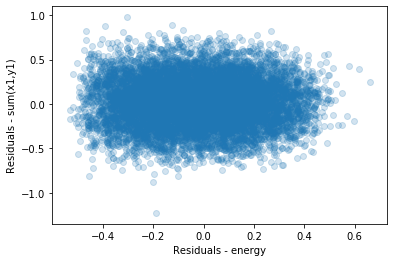

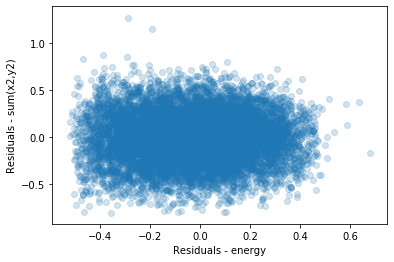

In [9]:
indices = np.random.choice(double, 10000, replace=False)

# Residuals in pos 1 vs residuals in energy 1
pos1_resid = np.sum(y_resid[:, :2], axis=1)
plt.scatter(y_resid[indices, 4], pos1_resid[indices], alpha=0.2)
plt.xlabel("Residuals - energy")
plt.ylabel("Residuals - sum(x1,y1)")
plt.show()

# Residuals in pos 2 vs residuals in energy 2
pos2_resid = np.sum(y_resid[:, 2:4], axis=1)
plt.scatter(y_resid[indices, 5], pos2_resid[indices], alpha=0.2)
plt.xlabel("Residuals - energy")
plt.ylabel("Residuals - sum(x2,y2)")
plt.show()

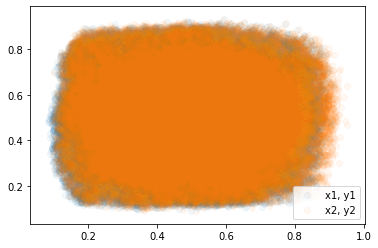

In [11]:
# Scatterplot predicted positions x1,y1 and target positions
plt.scatter(y_pred[double,0], y_pred[double,1], alpha=0.05, label="x1, y1")
plt.scatter(y_pred[double,2], y_pred[double,3], alpha=0.05, label="x2, y2")
plt.legend()
plt.show()

#pos_negative = double[np.where(y_pred[double, 2] < 0)[0]]
#pos_negative_two = double[np.where(y_pred[double, 3] < 0)[0]]
#pos_negative = np.array(list(set(pos_negative.tolist()).intersection(set(pos_negative.tolist()))))

#plt.scatter(y_pred[pos_negative, 2], y_pred[pos_negative, 3], alpha=0.2, label="predicted x2, y2")
#plt.xlabel("x2")
#plt.ylabel("y2")
#plt.legend()
#plt.show()




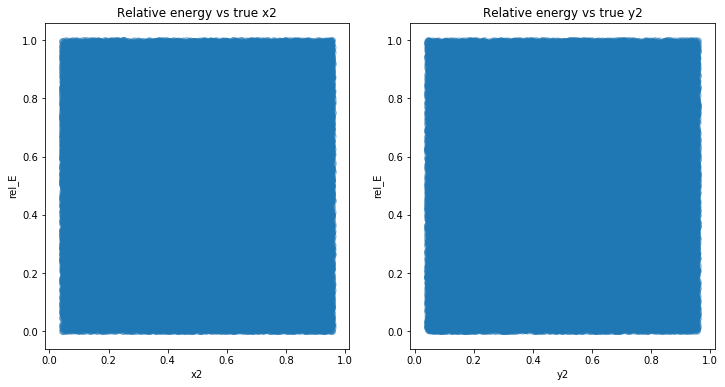

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(targets[double, 2], rel_E[double], alpha=0.2)
ax[0].set_title("Relative energy vs true x2")
ax[0].set_xlabel("x2")
ax[0].set_ylabel("rel_E")

ax[1].scatter(targets[double, 3], rel_E[double], alpha=0.2)
ax[1].set_title("Relative energy vs true y2")
ax[1].set_xlabel("y2")
ax[1].set_ylabel("rel_E")
plt.show()

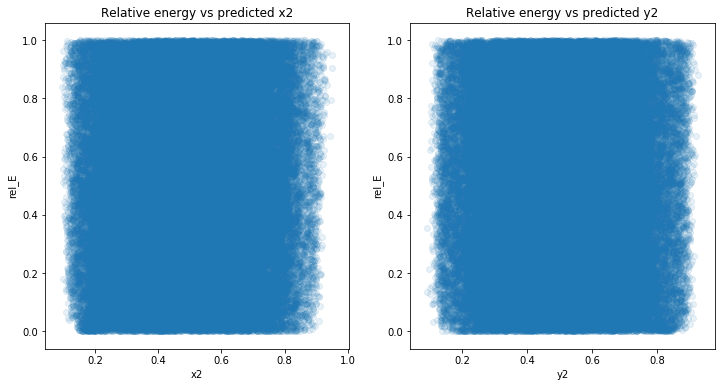

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(y_pred[double, 2], rel_E[double], alpha=0.1)
ax[0].set_title("Relative energy vs predicted x2")
ax[0].set_xlabel("x2")
ax[0].set_ylabel("rel_E")

ax[1].scatter(y_pred[double, 3], rel_E[double], alpha=0.1)
ax[1].set_title("Relative energy vs predicted y2")
ax[1].set_xlabel("y2")
ax[1].set_ylabel("rel_E")
plt.show()



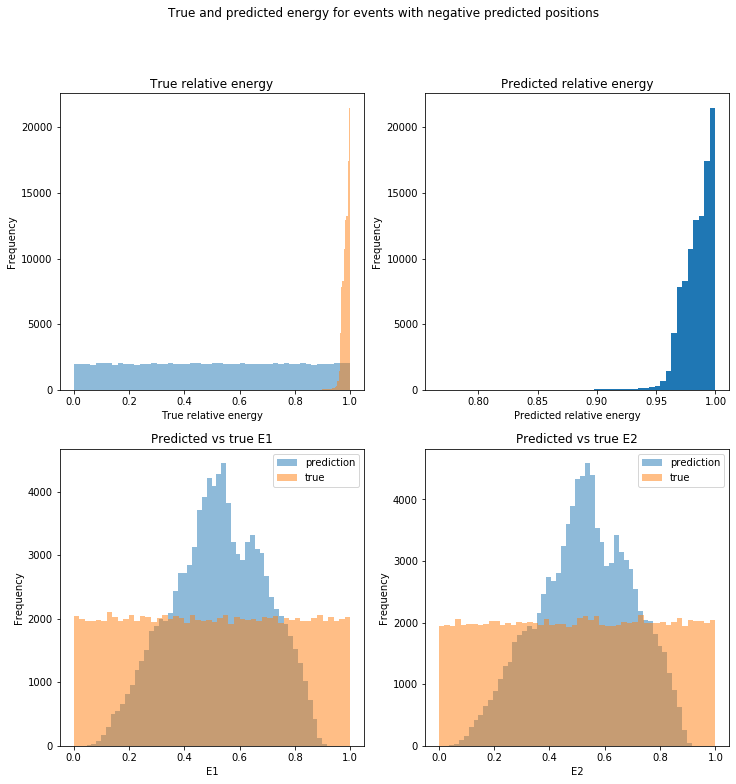

In [24]:
pred_rel_E = relative_energy(y_pred[:,4:])

fig, ax = plt.subplots(2,2, figsize=(12,12))
ax[0,0].hist(rel_E[double], bins=50, label="true", alpha=0.5)
ax[0,0].hist(pred_rel_E[double], bins=50, label="prediction", alpha=0.5)
ax[0,0].set_title("True relative energy")
ax[0,0].set_xlabel("True relative energy")
ax[0,0].set_ylabel("Frequency")
ax[0,1].hist(pred_rel_E[double], bins=50)
ax[0,1].set_title("Predicted relative energy")
ax[0,1].set_xlabel("Predicted relative energy")
ax[0,1].set_ylabel("Frequency")
ax[1,0].hist(y_pred[double, 4], bins=50, label="prediction", alpha=0.5)
ax[1,0].hist(targets[double, 4], bins=50, label="true", alpha=0.5)
ax[1,0].set_title("Predicted vs true E1")
ax[1,0].set_xlabel("E1")
ax[1,0].set_ylabel("Frequency")
ax[1,0].legend()
ax[1,1].hist(y_pred[double, 5], bins=50, label="prediction", alpha=0.5)
ax[1,1].hist(targets[double, 5], bins=50, label="true", alpha=0.5)
ax[1,1].set_title("Predicted vs true E2")
ax[1,1].set_xlabel("E2")
ax[1,1].set_ylabel("Frequency")
ax[1,1].legend()
fig.suptitle("True and predicted energy for events with negative predicted positions")
plt.show()